# Exercise 2: Implement a multi-stage compression pipeline in TensorFlow

You have explored how to design compression pipelines in theory. It is now time to move from ideas to implementation, and develop a modular multi-stage model compression pipeline in practice. 

> **Overview**: In this exercise, you'll implement a modular compression pipeline to reduce the size of a pre-trained ResNet50 model using post-training techniques. This represents a practical scenario where you need to deploy a large model to an edge device with limited resources.
> 
> **Goal**: Implement a modular compression pipeline that achieves at least 4× model size reduction (target: <23MB) while maintaining the best possible accuracy (<1% drop) on the Deep Learning task.
> 
> **Scenario**: You're working on the same security camera project from [Demo 1](../../demos/demo1-design-compression-pipeline.ipynb). Your task? To compress a ResNet50 model to unlock efficient image classification on a constrained edge environment. After designing an implementation strategy for compression, you are now ready to implement your Plan A: a multi-stage model compression pipeline consisting of post-training quantization (PTQ) and graph optimizations in TensorFlow. This pipeline is the quickest to implement and has the potential to meet the compression targets without much R&D.
> 
> **Tools**: TensorFlow, TensorFlow Model Optimization Toolkit, TensorFlow Datasets, LiteRT, matplotlib
> <br> _Prior experience recommended!_
> 
> **Estimated Time**: 15 minutes

## Step 1: Setup
Let's import the necessary libraries and load our model.

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install 'tensorflow[and-cuda]' tf_keras tensorflow-model-optimization tensorflow_datasets ai-edge-litert matplotlib

In [2]:
# Set TensorFlow logging level to ERROR to suppress warnings
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Force CPU usage for consistent results
os.environ['TF_USE_LEGACY_KERAS'] = '1'  # Ensure compatibility with tensorflow-model-optimization

> **Should we run on CPU or GPU?** For this exercise, GPU is recommended if available as processing can be slow on CPU given the large-sized model. But, some model compressions (INT8 quantization!) has to happen on CPU and inference speed evaluation would be more reliable on CPU too (even though, ultimately, you always need to test on device!). To keep the exercise time-constrained, we accept these limitations but feel free to experiment with different hardware settings!

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import tensorflow_model_optimization as tfmot
import tensorflow_datasets as tfds
from ai_edge_litert.interpreter import Interpreter
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from pathlib import Path
import random
import time
import contextlib

# Check if GPU is available
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
if tf.config.list_physical_devices('GPU'):
    print("CUDA Available: ", tf.test.is_built_with_cuda())
    gpus = tf.config.experimental.list_physical_devices('GPU')
    # Try to limit GPU memory growth to avoid OOM errors
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU found. Operations will run on CPU (this may be slow for training).")

# Set random seed for deterministic results
os.environ['PYTHONHASHSEED']=str(2)
tf.random.set_seed(2)
np.random.seed(2)
random.seed(2)

# Create output directory
output_dir = Path("assets/exercise2")
output_dir.mkdir(parents=True, exist_ok=True)

print("Setup complete!")

2025-05-20 18:49:34.956220: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747766975.593040    7806 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747766975.879535    7806 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747766978.026297    7806 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747766978.026358    7806 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747766978.026361    7806 computation_placer.cc:177] computation placer alr

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA Available:  True
Setup complete!


> **Memory management note**: Notice how we configure GPU memory growth (set_memory_growth(gpu, True)) to prevent TensorFlow from claiming all VRAM at startup. Despite this precaution, you may still encounter OOM errors during compression operations. If this happens, try: 
> 1. Reducing `BATCH_SIZE`
> 2. Forcing CPU execution for specific operations by temporarily setting `os.environ["CUDA_VISIBLE_DEVICES"]="-1"`
> 3. Further clearing the session with `tf.keras.backend.clear_session()` between stages
> 
> Quantization operations are particularly memory-intensive.

## Step 2: Load the dataset

First, let's load the dataset for our task. We'll use a subset of the [Imagenette dataset](https://www.tensorflow.org/datasets/catalog/imagenette) to speed things up. In a real scenario, you'd use more/different data.

In [4]:
# Define batch size for data loading / model training
# We keep it low in order to keep memory usage in check
BATCH_SIZE = 16

# Define all classes available in Imagenette with id and name
imagenette_classes = {
    'n01440764': 'tench',
    'n02102040': 'English springer',
    'n02979186': 'cassette player',
    'n03000684': 'chain saw',
    'n03028079': 'church',
    'n03394916': 'French horn',
    'n03417042': 'garbage truck',
    'n03425413': 'gas pump',
    'n03445777': 'golf ball',
    'n03888257': 'parachute'
}

# Define the subset of classes to use for our task
classes = ['chain saw', 'garbage truck', 'gas pump', 'parachute']
class_indices = [list(imagenette_classes.values()).index(c) for c in classes]
NUM_CLASSES = len(class_indices)
label_map = {orig_label: new_label for new_label, orig_label in enumerate(class_indices)}  # Create a dict to remap original labels to [0, NUM_CLASSES-1]
print(f"Using {NUM_CLASSES} classes: {classes} -> dataset indices {class_indices}.\nFinal class mapping: {label_map}")

Using 4 classes: ['chain saw', 'garbage truck', 'gas pump', 'parachute'] -> dataset indices [3, 6, 7, 9].
Final class mapping: {3: 0, 6: 1, 7: 2, 9: 3}


Loading datasets...


I0000 00:00:1747767002.141631    7806 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13764 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:06.0, compute capability: 7.5


Image shape: (224, 224, 3)


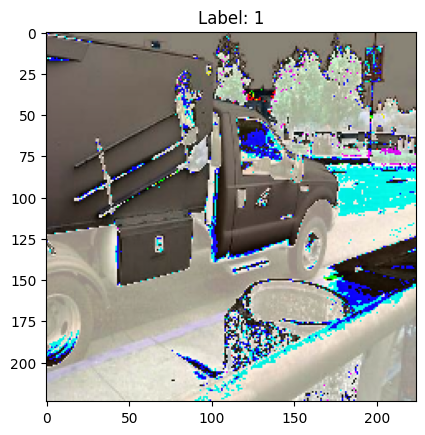

Datasets are ready with 3696 training samples and 1584 validation/test samples.


In [5]:
# Function to preprocess images for model input
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet.preprocess_input(image)
    label = label_table.lookup(label)  # Map labels to new indices
    label.set_shape([])
    return image, label
    
# Load Imagenette dataset
print("Loading datasets...")
tfds.disable_progress_bar()
train_ds_raw, val_ds_raw = tfds.load(
    'imagenette/320px-v2',  # Higher resolution version
    split=['train', 'validation'],
    as_supervised=True,
    with_info=False
)

# Filter dataset for our selected classes
tf_class_original_indices = tf.constant(list(label_map.keys()), dtype=tf.int64)
tf_class_final_indices = tf.constant(list(label_map.values()), dtype=tf.int64)
label_table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(tf_class_original_indices, tf_class_final_indices), 
    default_value=-1
)

# Process training dataset
train_dataset = train_ds_raw.filter(lambda img, lbl: tf.reduce_any(tf.equal(lbl, tf_class_original_indices))).map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Process validation dataset
validation_dataset = val_ds_raw.filter(lambda img, lbl: tf.reduce_any(tf.equal(lbl, tf_class_original_indices))).map(preprocess_dataset, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

# Optional: You could split off test set from val if needed
# For this exercise, we'll just treat validation_dataset as both val/test

# Visualize a sample
for images, labels in train_dataset.take(1):
    image, label = images[0], labels[0]
    print("Image shape:", image.shape)
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(f"Label: {label.numpy()}")
    plt.show()
    break

train_n_batches, validation_n_batches = sum(1 for _ in train_dataset), sum(1 for _ in validation_dataset)
print(f"Datasets are ready with {train_n_batches*BATCH_SIZE} training samples and {validation_n_batches*BATCH_SIZE} validation/test samples.")

> **Dataset and input visualization**: The sample image (garbage truck, Label 1) demonstrates our preprocessing pipeline: resizing to 224×224 to match ResNet50's input requirements, converting to float32, and applying ResNet-specific normalization. This preprocessing ensures compatibility with the original model architecture. 
> 
> When compressing models, visualize a consistent test set of images to benchmark accuracy before and after each compression stage. You may uncover some key visual features that model compression may reduce detection accuracy on!

## Step 3. Define the baseline model

Our baseline model consists of a ResNet50 adapted (via transfer learning) to be able to predict on the Imagenette dataset. 
This adaptation involves replacing the final classification layer and fine-tuning the model to get a baseline performance on our specific 4-class problem.

In [6]:
# Create and fine-tune the base model for our task
fine_tune_epochs = 1

def adapt_model_for_imagenette(num_classes=NUM_CLASSES):
    """
    Load ResNet50 and adapt its head for our dataset.
    Learn more at https://www.tensorflow.org/tutorials/images/transfer_learning.
    # """

    # Load the baseline model without head
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze the base_model initially
    base_model.trainable = False 
    
    # Add a new classification head for num_classes, with regularization via dropout
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3, name="top_dropout")(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    
    # Define the complete model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

# Create the model
base_model = adapt_model_for_imagenette()

# Compile the model
base_model.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)   

# Fine-tune the model on our task
print(f"Fine-tuning adapted ResNet50 head for {fine_tune_epochs} epoch(s)...")
if fine_tune_epochs > 0:
    history = base_model.fit(
        train_dataset, 
        epochs=fine_tune_epochs, 
        steps_per_epoch=train_n_batches,
        validation_data=validation_dataset, 
        validation_steps=validation_n_batches,
        verbose=1
    )
else:
    print("Skipping fine-tuning as fine_tune_epochs is 0.")

# TODO: Print a summary of the model architecture
# Hint: This is relevant to check what compression can be most efficient!
# See: https://www.tensorflow.org/api_docs/python/tf/keras/Model
# Add your one-line code here

# Save original adapted model for baseline comparison
baseline_model_path = output_dir / "baseline_model.keras"
base_model.save(baseline_model_path)
print(f"\nAdapted original model saved to {baseline_model_path}")

# Get model size in MB
def get_model_size(model_path):
    """Get model file size in MB"""
    # TODO: Calculate the model file size in megabytes (MB)
    # Hint: Get the file size in bytes and convert to MB 
    # See: https://docs.python.org/3/library/os.path.html
    model_size = # Add your code here
    return model_size
    
print(f"Adapted original model size: {get_model_size(baseline_model_path):.2f} MB")

Fine-tuning adapted ResNet50 head for 1 epoch(s)...


I0000 00:00:1747767038.013526    7931 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747767052.027982    7931 service.cc:152] XLA service 0x7f3e53771950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747767052.028036    7931 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5


  2/231 [..............................] - ETA: 15s - loss: 3.0710 - accuracy: 0.2500    

I0000 00:00:1747767053.725114    7931 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


231/231 [==============================] - 52s 136ms/step - loss: 0.1572 - accuracy: 0.9483 - val_loss: 0.0556 - val_accuracy: 0.9836
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         2

> **Transfer learning strategy**: We are using a pre-trained ResNet50 with a modified classification head for our 4-class problem. Notice the impressive 98.36% validation accuracy with just 1 epoch of fine-tuning - this is the power of transfer learning! You can study the model summary to identify compression opportunities: most parameters are in the later convolutional blocks, matching what we discovered in the demo about layers 3 and 4 containing ~80% of parameters.
> 
> _What about the model size?_ You may have spotted that the resulting 90.60MB model size differs from the demo's 97.8MB. That's because we have replaced the original 1000-class ImageNet classification head with our smaller 4-class head. Despite this difference, we'll maintain the original compression target (<23MB) from our security camera scenario. Our focus in this exercise is not on exact metrics, but on compression pipeline implementation!

## Step 4: Define evaluation utilities
Next, let's create utility functions that allows us to evaluate models in the Keras and TensorFlow Lite formats.

In [7]:
def _evaluate_keras_model(keras_model, eval_dataset, num_images=10):
    """
    Evaluates a Keras model on a dataset.
    """
        
    # Measure model size
    with tempfile.NamedTemporaryFile(suffix='.keras', delete=True) as tmp:
        keras_model.save(tmp.name, overwrite=True, save_format='keras')
        size_mb = get_model_size(tmp.name)
    
    # Measure model accuracy
    eval_results = keras_model.evaluate(eval_dataset, verbose=0, return_dict=True)
    accuracy = eval_results.get('accuracy', 0.0)

    # Measure inference time (run the benchmark for num_images)
    inference_times = []
    benchmark_images = eval_dataset.unbatch().take(num_images).prefetch(tf.data.AUTOTUNE)
    for image, _ in benchmark_images:
        image = tf.expand_dims(image, axis=0)  # retain batch dim
        start = time.time()
        _ = keras_model(image, training=False)
        inference_times.append((time.time() - start) * 1000)  # ms per image

    avg_inference_time_ms = np.mean(inference_times) if inference_times else 0.0
    return size_mb, accuracy, avg_inference_time_ms

In [8]:
def _evaluate_tflite_model(tflite_model_bytes, eval_dataset, num_images=10):
    """
    Evaluates a TFLite model on a dataset.
    Note that this function does not support int8 quantization (would need to handle the dtypes explicitly!).
    """

    # Measure model size
    size_mb = len(tflite_model_bytes) / (1024 * 1024)
    
    # TODO: Create and set up the LiteRT interpreter with the TFLite model
    # Hint: We have already imported the necessary class!
    # See: https://ai.google.dev/edge/api/tflite/python/tf/lite/Interpreter
    interpreter = # Add your code here

    # Define I/O details for the interpreter
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    # Measure inference time (run the benchmark for num_images)
    correct_predictions = 0
    total_predictions = 0
    inference_times = []

    images_processed = 0
    for batch_images, batch_labels in eval_dataset:
        # Stop when num_images has been reached
        for i in range(len(batch_images)):
            if images_processed >= num_images:
                break
                
        # Extract a single image and its label
        image_float32 = batch_images[i:i+1]  # Keep batch dimension
        label = batch_labels.numpy()[i]
        
        # TODO: Prepare the input_tensor.
        # Hint: Convert the TensorFlow tensor to the expected format by LiteRT; TensorFlow tensors have a built-in method for the conversion.
        # See: https://ai.google.dev/edge/litert/inference and https://www.tensorflow.org/api_docs/python/tf/Tensor
        input_tensor = # Add your code here
        
        interpreter.set_tensor(input_details['index'], input_tensor)
        
        start_time = time.time()
        interpreter.invoke()
        inference_times.append((time.time() - start_time) * 1000)  # ms per image
        
        output_tensor = interpreter.get_tensor(output_details['index'])
            
        predicted_class = np.argmax(output_tensor[0])
        if predicted_class == label:
            correct_predictions += 1
        total_predictions += 1
    
    avg_inference_time_val = np.mean(inference_times) if inference_times else 0
            
    # Measure model accuracy
    accuracy_val = correct_predictions / total_predictions if total_predictions > 0 else 0
    
    return size_mb, accuracy_val, avg_inference_time_val

> **Evaluation for edge deployment**: These utilities compare Keras and TFLite models using consistent metrics (size, accuracy, inference time). While these measurements are valuable for our pipeline development, they're proxies for actual performance. 
> 
> For production, always conduct final testing on your target hardware (ARM Cortex-A53) to account for device-specific behaviors. Consider adding metrics like power consumption and startup time that impact real-world security camera deployments.

## Step 5: Create a compression pipeline class

Now, let's create a modular `CompressionPipeline` class that allows you to chain multiple compression techniques and measure their impact on model size, accuracy, and inference speed.

In [13]:
class CompressionPipeline:
    """A class to apply and evaluate a sequence of model compression techniques.
    
    This class provides a flexible way to chain multiple compression techniques
    and track their impact on model size, accuracy, and inference speed.
    """
    def __init__(self, baseline_model, name="compression_pipeline"):
        # TODO: Initialize all CompressionPipeline class attributes
        # Hint: Review the class implementation for `self.` attributes and add the missing 2 attributes here!
        self.name = name
        self.current_model = baseline_model  # Initialize with the baseline model
        self.baseline_model = baseline_model
        self.stages = []
        self.metrics = {
            "original_size_mb": None, "current_size_mb": None, "compression_ratio": 1.0,
            "original_inference_time_ms": None, "current_inference_time_ms": None, "speedup": 1.0,
            "original_accuracy": None, "current_accuracy": None, "accuracy_drop": 0.0
        }
        # Add your code here

    def add_stage(self, name, technique_fn, *args, **kwargs):
        """Add a compression technique to the pipeline.
        
        Args:
            name: Name of the compression stage
            technique_fn: Function that applies the compression technique
            *args, **kwargs: Arguments to pass to the technique function
            
        Returns:
            Self reference for method chaining
        """
        self.stages.append({
            "name": name,
            "function": technique_fn,
            "args": args,
            "kwargs": kwargs
        })
        return self

    def _initialize_baseline_metrics(self, eval_dataset):
        """Compute and save the metrics for the baseline model."""
        print("Initializing baseline metrics for the original Keras model...")

        temp_original_model = self.baseline_model  # No need to clone if not modifying for baseline eval

        self.metrics["original_size_mb"], self.metrics["original_accuracy"], self.metrics["original_inference_time_ms"] = _evaluate_keras_model(self.baseline_model, eval_dataset)

        # Initialize current metrics to original values
        self.metrics["current_size_mb"] = self.metrics["original_size_mb"]
        self.metrics["current_accuracy"] = self.metrics["original_accuracy"]
        self.metrics["current_inference_time_ms"] = self.metrics["original_inference_time_ms"]

        self._baseline_metrics_initialized = True
        print("Baseline metrics initialized.")

    def evaluate_model(self, eval_dataset):
        """Evaluate the current model state and update metrics."""

        if not self._baseline_metrics_initialized:
            self._initialize_baseline_metrics(eval_dataset)
        
        print("\nEvaluating current model state...")
        current_model_is_keras = isinstance(self.current_model, tf.keras.Model)
        current_model_is_tflite_bytes = isinstance(self.current_model, bytes)

        current_size_mb, current_accuracy, current_inference_time_ms = None, None, None

        if current_model_is_keras:
            # Evaluate Keras model
            current_size_mb, current_accuracy, current_inference_time_ms = _evaluate_keras_model(self.current_model, eval_dataset)
        elif current_model_is_tflite_bytes:
            # Evaluate TFLite model
            current_size_mb, current_accuracy, current_inference_time_ms = _evaluate_tflite_model(self.current_model, eval_dataset)
        else:
            print("Warning: Unknown model type for evaluation.")
            current_size_mb, current_accuracy, current_inference_time_ms = self.metrics["original_size_mb"], 0, float('inf')

        self.metrics["current_size_mb"] = current_size_mb
        self.metrics["current_accuracy"] = current_accuracy
        self.metrics["current_inference_time_ms"] = current_inference_time_ms

        # Calculate derived metrics
        if self.metrics["original_size_mb"] and self.metrics["current_size_mb"] and self.metrics["original_size_mb"] > 0:
            self.metrics["compression_ratio"] = self.metrics["original_size_mb"] / self.metrics["current_size_mb"]
        else: self.metrics["compression_ratio"] = 1.0

        if self.metrics["original_inference_time_ms"] and self.metrics["current_inference_time_ms"] and self.metrics["current_inference_time_ms"] > 0:
            self.metrics["speedup"] = self.metrics["original_inference_time_ms"] / self.metrics["current_inference_time_ms"]
        else: self.metrics["speedup"] = 1.0
        
        if self.metrics["original_accuracy"] and self.metrics["current_accuracy"] is not None:
            self.metrics["accuracy_drop"] = self.metrics["original_accuracy"] - self.metrics["current_accuracy"]
        else: self.metrics["accuracy_drop"] = self.metrics["original_accuracy"] if self.metrics["original_accuracy"] else 0.0

        self.print_metrics()
        return self.metrics

    def execute(self, eval_dataset):
        print(f"\n===== Starting Pipeline: {self.name} =====")
        if not self._baseline_metrics_initialized:
            self._initialize_baseline_metrics(eval_dataset)
            self.print_metrics() 

        for i, stage in enumerate(self.stages):
            # Clear memory before each stage
            tf.keras.backend.clear_session()
            
            print(f"\n--- Executing Stage {i+1}/{len(self.stages)}: {stage['name']} ---")
            # TODO: Execute the current stage's function with the appropriate arguments
            # Hint: Call the stage's function with the current model and any additional args/kwargs from the `stage`
            self.current_model =  # Add your code here
            # TODO: Evaluate after each stage
            # Hint: Call one of the class methods with the evaluation dataset as an argument
            # Add your one-line code here

            # Store metrics for this stage
            self.stage_metrics.append({
                "name": stage["name"],
                "size_mb": self.metrics["current_size_mb"],
                "inference_time_ms": self.metrics["current_inference_time_ms"],
                "accuracy": self.metrics["current_accuracy"]
            })
        
        print(f"\n===== Pipeline {self.name} Execution Complete! =====")
        self.print_metrics()  # Print final metrics
        print("===============================================")
        return self.current_model

    def print_metrics(self):
        print(f"--- Current Model Metrics ({self.name}) ---")
        print(f"  Size: {self.metrics['current_size_mb']:.2f} MB (Original: {self.metrics.get('original_size_mb', 0):.2f} MB)")
        print(f"  Compression Ratio: {self.metrics['compression_ratio']:.2f}x")
        if self.metrics["current_inference_time_ms"] is not None and self.metrics.get("original_inference_time_ms") is not None:
            print(f"  Inference Time (per image): {self.metrics['current_inference_time_ms']:.2f} ms (Original: {self.metrics['original_inference_time_ms']:.2f} ms)")
            print(f"  Speedup: {self.metrics['speedup']:.2f}x")
        if self.metrics["current_accuracy"] is not None and self.metrics.get("original_accuracy") is not None:
            print(f"  Accuracy: {self.metrics['current_accuracy']:.4f} (Original: {self.metrics['original_accuracy']:.4f})")
            print(f"  Accuracy Drop: {self.metrics['accuracy_drop']:.4f}")
        print("-------------------------")
    
    def visualize_results(self):
        if not self._baseline_metrics_initialized:
            print("Execute the pipeline first to get metrics for visualization.")
            return
        
        # Create a list that includes original, intermediate stages, and final
        stage_names = ["Original"]
        size_values = [self.metrics["original_size_mb"]]
        inference_values = [self.metrics.get("original_inference_time_ms", 0) or 0]
        accuracy_values = [(self.metrics["original_accuracy"] * 100) if self.metrics["original_accuracy"] is not None else 0]
        
        # Add intermediate stage metrics if they exist
        if hasattr(self, 'stage_metrics') and self.stage_metrics:
            for stage in self.stage_metrics:
                stage_names.append(stage["name"])
                size_values.append(stage["size_mb"])
                inference_values.append(stage["inference_time_ms"])
                accuracy_values.append((stage["accuracy"] * 100))
        
        # Create a figure with 3 subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot Size
        axes[0].bar(range(len(stage_names)), size_values, color="#3498db")
        axes[0].set_ylabel("Size (MB)")
        axes[0].set_title("Model Size")
        axes[0].set_xticks(range(len(stage_names)))
        axes[0].set_xticklabels(stage_names, rotation=45, ha='right')
        axes[0].plot(range(len(stage_names)), size_values, 'o-', color='black', alpha=0.6)
        axes[0].axhline(y=23, color='r', linestyle='--', label="Target (23MB)")
        axes[0].legend()
        
        # Add compression ratio annotation
        if len(size_values) >= 2:
            compression = size_values[0] / size_values[-1]
            axes[0].text(0.5, 0.95, f"Compression: {compression:.2f}x", 
                        ha='center', transform=axes[0].transAxes, 
                        bbox=dict(facecolor='yellow', alpha=0.5))
        
        # Plot Inference Time
        axes[1].bar(range(len(stage_names)), inference_values, color="#2ecc71")
        axes[1].set_ylabel("Inference Time (ms/img)")
        axes[1].set_title("Inference Time")
        axes[1].set_xticks(range(len(stage_names)))
        axes[1].set_xticklabels(stage_names, rotation=45, ha='right')
        axes[1].plot(range(len(stage_names)), inference_values, 'o-', color='black', alpha=0.6)
        
        # Add speedup annotation
        if len(inference_values) >= 2 and inference_values[-1] > 0:
            speedup = inference_values[0] / inference_values[-1]
            axes[1].text(0.5, 0.95, f"Speedup: {speedup:.2f}x", 
                        ha='center', transform=axes[1].transAxes,
                        bbox=dict(facecolor='yellow', alpha=0.5))
        
        # Plot Accuracy
        axes[2].bar(range(len(stage_names)), accuracy_values, color="#e74c3c")
        axes[2].set_ylabel("Accuracy (%)")
        axes[2].set_title("Model Accuracy")
        axes[2].set_xticks(range(len(stage_names)))
        axes[2].set_xticklabels(stage_names, rotation=45, ha='right')
        axes[2].plot(range(len(stage_names)), accuracy_values, 'o-', color='black', alpha=0.6)
        axes[2].set_ylim([min(min(accuracy_values) - 5, 80), 105])
        
        # Add accuracy drop annotation
        if len(accuracy_values) >= 2:
            drop = accuracy_values[0] - accuracy_values[-1]
            axes[2].text(0.5, 0.95, f"Accuracy Drop: {drop:.2f}%", 
                        ha='center', transform=axes[2].transAxes,
                        bbox=dict(facecolor='orange', alpha=0.5))
        
        # Add value labels on top of bars
        for ax, values in zip(axes, [size_values, inference_values, accuracy_values]):
            for i, v in enumerate(values):
                ax.text(i, v + 0.01 * max(values), f"{v:.2f}{'' if ax != axes[2] else '%'}", 
                    ha='center', va='bottom', fontsize=9)
        
        fig.suptitle(f'Compression Pipeline Results: {self.name}', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

> **Pipeline design pattern**: The `CompressionPipeline` class implements a useful design pattern for model optimization. Its modular architecture lets you chain compression techniques, track metrics at each stage, and cleanly separate technique implementation from evaluation. This approach has several advantages: 
> 1. **Flexibility**: You can easily experiment with different technique sequences
> 2.  **Maintainability**: Each compression step is isolated for better debugging
> 3. **Measurability**: The evaluation and visualization tools help identify which techniques provide the most benefit across stages
> 4. **Reusability**: You can reuse this framework for different models and projects. This pattern follows software engineering best practices by making your compression workflow maintainable and extensible.

## Step 6: Implement the compression techniques

Now, let's define the individual compression techniques that we'll use in our pipelines.

In [11]:
def apply_post_training_quantization(model, **kwargs):
    """
    Converts a floating-point model to a fixed-point quantized model using TFLite.

    Note: We're skipping int8 quantization as it requires switching to CPU and it can be memory-intensive. 
    For a complete production pipeline, you would implement full int8 quantization with a representative dataset.
    """

    print("Applying post-training quantization...")
        
    # TODO: Create a TFLite converter for quantization
    # See https://www.tensorflow.org/lite/performance/post_training_quantization
    converter = # Add your code here

    # TODO: Set up your preferred optimization strategy 
    # See: https://ai.google.dev/edge/api/tflite/python/tf/lite/Optimize
    # Add your one-line code here

    ## Skipping it8 quantization since it requires more memory (server could crash with INT8)
    
    # Convert the model
    tflite_model = converter.convert()
    
    print(f"Model quantized")

    return tflite_model

def apply_graph_optimization(model, **kwargs):
    """
    Apply specific graph optimizations to improve inference performance.
    """
    
    print("Applying graph optimizations...")
    
    # Create a context manager to safely apply and restore optimizer options
    # Documentation: https://www.tensorflow.org/guide/graph_optimization
    @contextlib.contextmanager
    def optimizer_options(options):
        old_opts = tf.config.optimizer.get_experimental_options()  # Save original options to restore later
        tf.config.optimizer.set_experimental_options(options)  # Set new options
        try:
            yield  # Allow code within the context to execute
        finally:
            tf.config.optimizer.set_experimental_options(old_opts)  # Restore original options
    
    # TODO: Define optimizations to apply
    # Hint: Set up your preferred optimization from https://www.tensorflow.org/guide/graph_optimization#available_graph_optimizers
    # See: https://www.tensorflow.org/api_docs/python/tf/config/optimizer/set_experimental_options 
    optimizations = {}  # Add your code here
    
    # Print which optimizations will be applied
    enabled_opts = [k for k, v in optimizations.items() if v is True]
    print(f"Enabling optimizations: {', '.join(enabled_opts)}")
    
    # TODO: Apply optimizations and save/load the model to ensure they take effect
    # Hint: You just need to save the model within the optimizer_options context
    # Recommended to set options=tf.saved_model.SaveOptions(experimental_custom_gradients=False during model saving to remove gradient-related operations which are not used for inference
    # See: https://www.tensorflow.org/api_docs/python/tf/keras/models/save_model
    temp_dir = tempfile.mkdtemp()
    with optimizer_options(optimizations):
        # Add your one-line code here
    
    # Load the optimized model
    optimized_model = tf.keras.models.load_model(temp_dir)
    print(f"Applied graph optimizations via SavedModel")
        
    return optimized_model

> **Extending compression techniques**: These implementations represent just two of many possible compression methods. To expand this pipeline, you could add any new compression function such as `apply_weight_pruning()` or `apply_knowledge_distillation()`. 
> 
> Each new function would follow the same pattern: accept a model, apply a transformation, return the transformed model. This modular approach lets you integrate additional techniques without modifying the pipeline structure, making your compression toolkit easily extensible for different deployment scenarios.

## Step 7: Implement the compression pipeline

Now, let's implement the compression pipeline Plan A designed in Demo 1. This is quick post-training approach that doesn't require additional training. This pipeline consists of two stages:

- Graph optimizations - to improve the model structure and operation efficiency
- Post-training quantization - to reduce the memory footprint by converting from floating-point to fixed-point

**IMPORTANT**: We run graph optimization before post-training quantization as there is better customization support of graph optimizations for Keras models rather than TFLite models. This is because TFLite applies some optimizations automatically during conversion.


Executing Plan A: Post-Training Pipeline (PTQ + Graph Optimization)

===== Starting Pipeline: plan_a_graph_ptq =====
Initializing baseline metrics for the original Keras model...
Baseline metrics initialized.
--- Current Model Metrics (plan_a_graph_ptq) ---
  Size: 90.56 MB (Original: 90.56 MB)
  Compression Ratio: 1.00x
  Inference Time (per image): 246.24 ms (Original: 246.24 ms)
  Speedup: 1.00x
  Accuracy: 0.9836 (Original: 0.9836)
  Accuracy Drop: 0.0000
-------------------------

--- Executing Stage 1/2: Graph Optimization ---
Applying graph optimizations...
Enabling optimizations: layout_optimizer, constant_folding, shape_optimization, remapping, arithmetic_optimization, dependency_optimization, loop_optimization, function_optimization, debug_stripper
INFO:tensorflow:Assets written to: /tmp/tmpda36sxtt/assets


INFO:tensorflow:Assets written to: /tmp/tmpda36sxtt/assets


Applied graph optimizations via SavedModel

Evaluating current model state...
--- Current Model Metrics (plan_a_graph_ptq) ---
  Size: 90.57 MB (Original: 90.56 MB)
  Compression Ratio: 1.00x
  Inference Time (per image): 132.38 ms (Original: 246.24 ms)
  Speedup: 1.86x
  Accuracy: 0.9836 (Original: 0.9836)
  Accuracy Drop: 0.0000
-------------------------

--- Executing Stage 2/2: Post-Training Quantization ---
Applying post-training quantization...
INFO:tensorflow:Assets written to: /tmp/tmpf71c0yph/assets


INFO:tensorflow:Assets written to: /tmp/tmpf71c0yph/assets
W0000 00:00:1747767225.688553    7806 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747767225.731457    7806 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1747767226.367498    7806 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


Model quantized

Evaluating current model state...


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


--- Current Model Metrics (plan_a_graph_ptq) ---
  Size: 22.81 MB (Original: 90.56 MB)
  Compression Ratio: 3.97x
  Inference Time (per image): 199.71 ms (Original: 246.24 ms)
  Speedup: 1.23x
  Accuracy: 0.9899 (Original: 0.9836)
  Accuracy Drop: -0.0063
-------------------------

===== Pipeline plan_a_graph_ptq Execution Complete! =====
--- Current Model Metrics (plan_a_graph_ptq) ---
  Size: 22.81 MB (Original: 90.56 MB)
  Compression Ratio: 3.97x
  Inference Time (per image): 199.71 ms (Original: 246.24 ms)
  Speedup: 1.23x
  Accuracy: 0.9899 (Original: 0.9836)
  Accuracy Drop: -0.0063
-------------------------


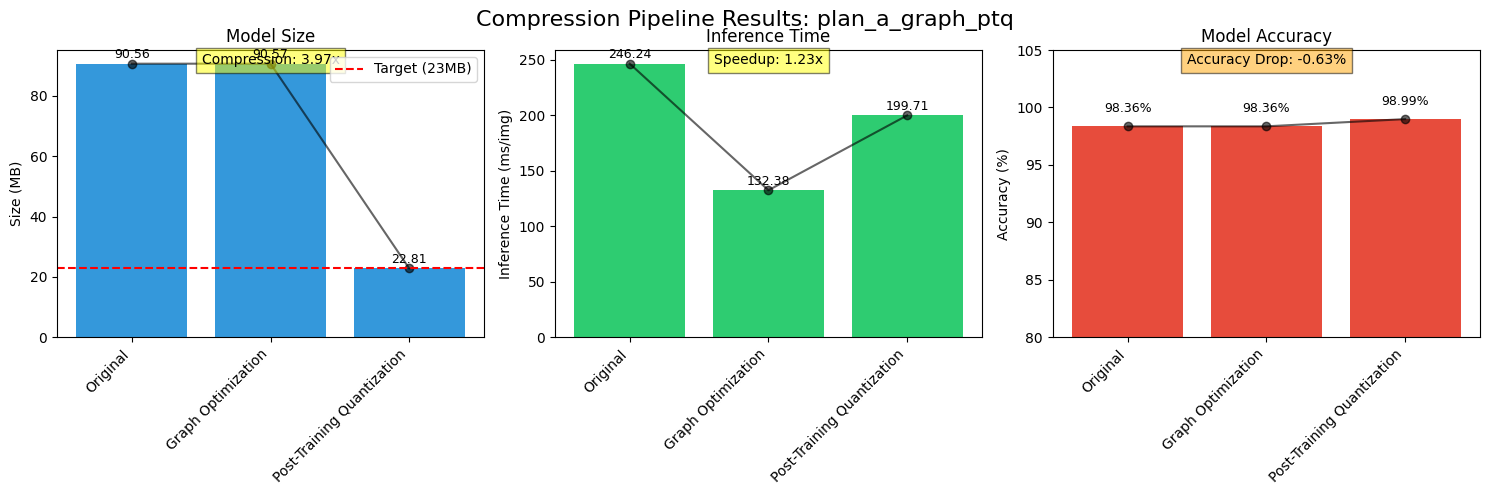

In [14]:
# Clear TensorFlow's internal graph state and GPU memory
tf.keras.backend.clear_session()

# Load the base model again
base_model_a = adapt_model_for_imagenette() 
base_model_a.load_weights(baseline_model_path)
base_model_a.compile(
    optimizer='SGD',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)   

# TODO: Create the CompressionPipeline
# Hint: simply add_stage() for each chosen step (name, function) in the right order! 
pipeline_a = CompressionPipeline(base_model_a, name="plan_a_graph_ptq")
# Add your code here

# Execute the pipeline
print("\nExecuting Plan A: Post-Training Pipeline (PTQ + Graph Optimization)")
model_a_compressed = pipeline_a.execute(validation_dataset)
pipeline_a.visualize_results()

> **Compression results analysis**: Our pipeline achieves around the target compression (3.97x to 22.81MB), but note the interesting performance pattern: graph optimization provided excellent speedup (1.86x), but adding quantization partially reduced this gain (final 1.23x). This likely occurs because our testing environment isn't optimized for TFLite execution - desktop CPUs often handle floating-point operations more efficiently than quantized ones.
> 
> _What about accuracy?_ The accuracy results are also noteworthy - our model maintains or even slightly improves accuracy (+0.63%) after compression. While encouraging, this might not translate perfectly to edge devices and performance should be validated with extensive data on device.

## Conclusion

In this exercise, you've implemented a multi-stage compression pipeline using post-training techniques. The pipeline combines graph optimization and post-training quantization to reduce the model size while maintaining acceptable accuracy.

Key takeaways from this exercise include:

- The importance of a modular pipeline design for flexibility and evaluation
- How different compression techniques affect model size, accuracy, and inference speed
- The necessity of evaluating the final TFLite model to see true compression benefits
- Understanding the trade-offs between model size and accuracy

If our compression pipeline met all the requirements (size reduction to under 23MB with acceptable accuracy loss), the TFLite model is ready for deployment testing. If not, you might need to explore additional compression techniques (possibly following the strategic plan designed in Demo 1).

By implementing this compression pipeline, you've gained practical experience with a modular design pattern that can be extended to other models and deployment scenarios in your future work.